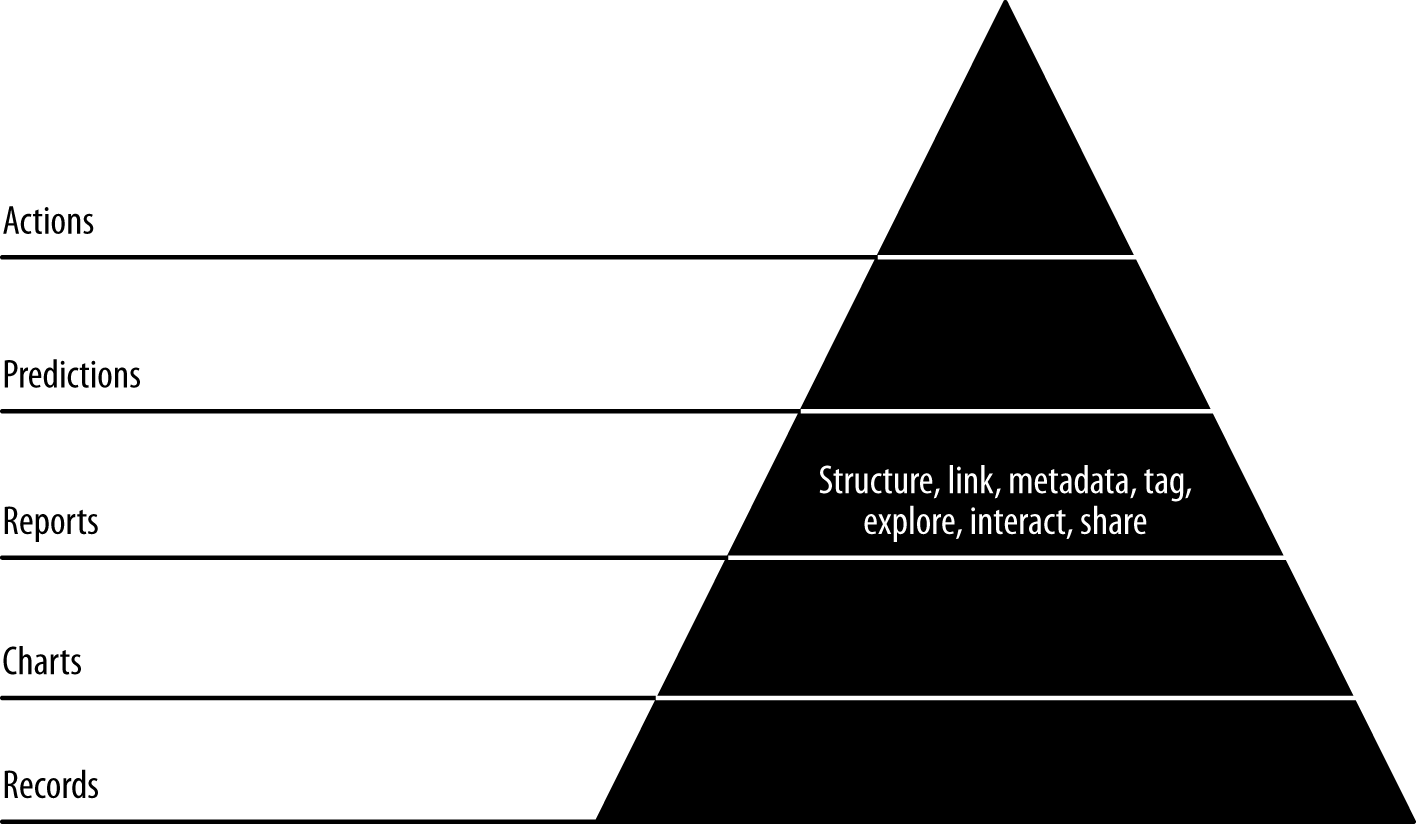

In the next step, our third agile sprint, we’ll extend our chart pages into full-blown reports. In this step, charts become interactive, static pages become dynamic, and our data becomes explorable through networks of linked, related entities with tables and charts. These are the characteristics of the reports stage of the data-value pyramid.

In [ ]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

## Extracting Airlines (Entities)

To build a report, we need to compose multiple views of our dataset. Building these views corresponds with enumerating entities. The entity we created in the previous chapter, airplanes, will serve as a foundation as we increase the number of entities and the corresponding links between them to create reports. As with the last chapter, before we can start creating different views on our data, we need a web page to put our charts and tables into. So let’s create another entity, airlines, and give each a page of its own.

We start by gathering all tail numbers for a given airline in a table on its entity page. Every commercial flight has an airline it operates under, and each airline has a fleet of beautifully branded airplanes that, along with airport facilities and staff, are the key assets of its business. We already created a page for each airplane, so we’ll leverage this data asset to create a list of all tail numbers for each airline.

### Defining Airlines as Groups of Airplanes Using PySpark

We begin by preparing the lists of tail numbers for each airline code, in [ch06/extract_airlines.py](extract_airlines.py). These will form the basis for our airline pages:

In [ ]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers foreach airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_airplane = spark.sql(
  "SELECT DISTINCT Carrier, TailNum FROM on_time_performance"
)

# Now we need to store a sorted list of tail numbers for each carrier, along with a fleet count
airplanes_per_carrier = carrier_airplane.rdd\
  .map(lambda nameTuple: (nameTuple[0], [nameTuple[1]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'Carrier': tuple[0], 
        'TailNumbers': sorted(
          filter(
            lambda x: x != '', tuple[1] # empty string tail numbers were 
                                        # getting through
            )
          ),
        'FleetCount': len(tuple[1])
      }
    )

# Determine the total number of airlines in the dataset
total_airlines = airplanes_per_carrier.count()
print("Total airlines making up US fleet: {}".format(total_airlines))

# Inspect one of our records now that they're prepared to be published in MongoDB
airplanes_per_carrier.first()

#### Storing to MongoDB

Next we'll store this data in the `airplanes_per_carrier` collection.

In [ ]:
# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
airplanes_per_carrier.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplanes_per_carrier'
)

#### Verifying Records in MongoDB

In [4]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.count()'
mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.findOne()'

14
{
	"_id" : ObjectId("57c369bfa68a98e72d30416f"),
	"TailNumbers" : [
		"N281VA",
		"N282VA",
		"N283VA",
		"N284VA",
		"N361VA",
		"N521VA",
		"N522VA",
		"N523VA",
		"N524VA",
		"N525VA",
		"N526VA",
		"N527VA",
		"N528VA",
		"N529VA",
		"N530VA",
		"N621VA",
		"N622VA",
		"N623VA",
		"N624VA",
		"N625VA",
		"N626VA",
		"N627VA",
		"N628VA",
		"N629VA",
		"N630VA",
		"N631VA",
		"N632VA",
		"N633VA",
		"N634VA",
		"N635VA",
		"N636VA",
		"N637VA",
		"N638VA",
		"N639VA",
		"N640VA",
		"N641VA",
		"N642VA",
		"N835VA",
		"N836VA",
		"N837VA",
		"N838VA",
		"N839VA",
		"N840VA",
		"N841VA",
		"N842VA",
		"N843VA",
		"N844VA",
		"N845VA",
		"N846VA",
		"N847VA",
		"N848VA",
		"N849VA",
		"N851VA",
		"N852VA",
		"N853VA",
		"N854VA",
		"N855VA"
	],
	"Carrier" : "VX",
	"FleetCount" : 57
}


### Building an Airline Page in Flask

Next we’ll create a controller for our airline page. Check out [ch06/web/report_flask.py](web/report_flask.py).

#### Airline Page Controller

Our Flask controller is simple. It accepts an airline carrier code and returns a page with a list of airplanes, by tail number, from Mongo:

```python
# Controller: Fetch an airplane entity page
@app.route("/airlines/<carrier_code>")
def airline(carrier_code):
  airline_airplanes = client.agile_data_science.airplanes_per_carrier.find_one(
    {'Carrier': carrier_code}
  )
  return render_template(
    'airlines.html',
    airline_airplanes=airline_airplanes,
    carrier_code=carrier_code
  )
```

#### Airline Page Template

Our template code creates an HTML bullet for each tail number. Check out [ch06/web/templates/airlines.html](web/templates/airlines.html):

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a> / <a href="/airlines/{{carrier_code}}">{{carrier_code}}</a>

  <!-- Summary -->
  <p style="text-align: justify;">{{airline_summary.summary}}</p>
  <h4>Fleet: {{airline_airplanes.FleetCount}} Planes</h4>
  <ul class="nav nav-pills">
    {% for tail_number in airline_airplanes.TailNumbers -%}
    <li class="button">
      <a href="/airplanes/{{tail_number}}">{{tail_number}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

Now in a terminal, change directory to `ch06/web` and run the file `report_flask.py`:

```bash
cd ch06/web
python ./report_flask.py
```

#### Airline Page Result

Now you can visit the resulting web page at [http://localhost:5000/airlines/DL](http://localhost:5000/airlines/DL):

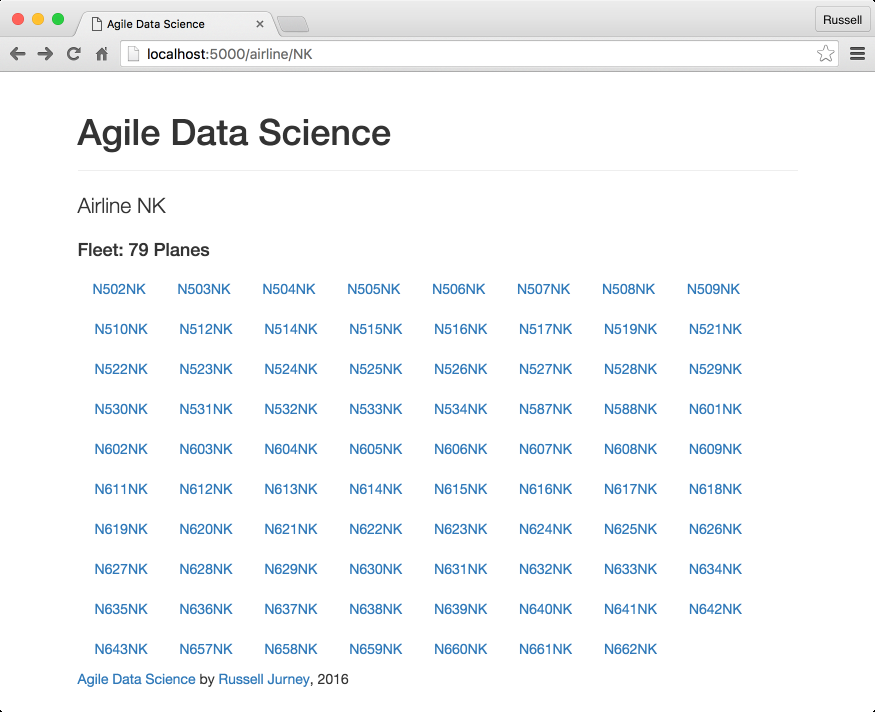

The result is the start of an airline page detailing its entire fleet. Don’t worry, we’ll dress this up later. It is absolutely necessary to ship something ugly before you ship something sharp!

### Linking Back to Our Airline Page

Having created the airline entity page type, we will now link back to it from the airplane page we created, and the search and flight pages in from Chapter 5. We do this by editing the templates for the airplane, flight, and search pages.

Check out [ch06/web/templates/flights_per_airplane.html](web/templates/flights_per_airplane.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights['Flights'] %}
        <tr>
          <td><a href="/airline/{{flight['Carrier']}}">{{flight['Carrier']}}</a></td>
          <td>{{flight['FlightDate']}}</td>
          <td><a href="/on_time_performance?Carrier={{flight['Carrier']}}&FlightDate={{flight['FlightDate']}}&FlightNum={{flight['FlightNum']}}">{{flight['FlightNum']}}</a></td>
          <td>{{flight['Origin']}}</td>
          <td>{{flight['Dest']}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Also [ch06/web/templates/flight.html](web/templates/flight.html):

```html
    <table class="table">
      <thead>
        <th>Airline</th>
        <th>Origin</th>
        <th>Destination</th>
        <th>Tail Number</th>
        <th>Date</th>
        <th>Air Time</th>
        <th>Distance</th>
      </thead>
      <tbody>
        <tr>
          <td><a href="/airline/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td><a href="/airplane/flights/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
      </tbody>
    </table>
```

And finally [ch06/web/templates/search.html](web/templates/search.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights %}
        <tr>
          <td><a href="/airline/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td><a href="/on_time_performance?Carrier={{flight.Carrier}}&FlightDate={{flight.FlightDate}}&FlightNum={{flight.FlightNum}}">{{flight.FlightNum}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.DepTime}}</td>
          <td><a href="/airplane/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```



## Creating an All Airlines Home Page

But who knows airline carrier codes (okay, other than me)? We need a way to get users started browsing, so let’s create a home page listing all the airlines operating in the US.

Our controller is simple, just six lines of code. We’re able to reuse the airlines_per_carrier MongoDB collection, this time ignoring the tail numbers and only querying the carrier codes using a find. Let’s also direct users to this page by default, as our index.html for this application:

```python
# Controller: Fetch an airplane entity page
@app.route("/")
@app.route("/airlines")
@app.route("/airlines/")
def airlines():
  airlines = client.agile_data_science.airplanes_per_carrier.find()
  return render_template('all_airlines.html', airlines=airlines)
```

Our template is similar to the one for an individual airline:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a>

  <p class="lead">US Domestic Airlines</p>
  <ul class="nav nav-pills">
    {% for airline in airlines -%}
    <li class="button">
      <a href="/airline/{{airline.Carrier}}">{{airline.Carrier}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

The result is a simple but effective way to get users browsing the world of aviation. Check out [http://localhost:5000/](http://localhost:5000):

![ads2_0603.png](attachment:ads2_0603.png)

